# Auto-ajuste de hiperparámetros por búsqueda de cuadrícula (grid-search)

## Nuestro modelo predictivo

In [2]:
from sklearn import set_config

set_config(display="diagram")

In [3]:
import pandas as pd

adult_census = pd.read_csv("../../data/adult-census-numeric/full.csv")

In [4]:
# Extraemos la columna que contiene el objetivo.

target_name = "class"
target = adult_census[target_name]
target

0         <=50K
1         <=50K
2          >50K
3          >50K
4         <=50K
          ...  
48837     <=50K
48838      >50K
48839     <=50K
48840     <=50K
48841      >50K
Name: class, Length: 48842, dtype: object

In [5]:
# Quitamos el objetivo de los datos y la columna "Education-Num" (duplicado de "Educación").

data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,Some-college,Never-married,?,Own-child,White,Female,0,0,30,United-States


In [6]:
# La dividimos en un conjunto de entrenamiento y prueba.

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42)

In [7]:
# Definiremos un piepline. Gestionará características numéricas y categóricas.

# seleccionar todas las columnas categóricas.

from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

Aquí usaremos un modelo basado en árbol como clasificador (`HistgradientBoostingClassifier`).
Esto significa que:
- las variables numéricas no necesitan escala;
- las variables categóricas se pueden tratar con un entorno ordinal incluso si el orden de codificación no es significativo;
- para los modelos basados ​​en árboles, OrdinalEncoder evita tener representaciones de alta dimensión.

In [8]:
# Ahora construimos nuestro OrdinalEncoder pasando las categorías conocidas.

from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value",
                                          unknown_value=-1)

In [9]:
# usamos un ColumnTransformer para seleccionar las columnas categóricas y aplicar el OrdinalEncoder a ellas.

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('cat_preprocessor', categorical_preprocessor, categorical_columns)],
    remainder='passthrough', sparse_threshold=0)

In [10]:
# Finalmente, usamos un clasificador basado en árbol (histogram gradient-boosting) para predecir si una persona gana o no más de 50 K$ al año.

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))])

model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Ajustar con búsqueda de cuadrícula
- Usamos el **estimador GridSearchCV** para hacer la búsqueda.
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- Dado que la búsqueda de la cuadrícula será costosa, solo exploraremos la combinación `learning_rate` y `max_leaf_nodes`.

In [11]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__learning_rate': (0.01, 0.1, 1, 10),
    'classifier__max_leaf_nodes': (3, 10, 31, 50)
}

model_grid_search = GridSearchCV(model, param_grid=param_grid, cv=2)

model_grid_search.fit(data_train,target_train)

CPU times: user 13.4 s, sys: 145 ms, total: 13.5 s
Wall time: 13.5 s


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          sparse_threshold=0,
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             param_grid={'classifier__learning_rate': (0.01, 0.1, 1, 10),
                         'classifier__max_leaf_nodes': (3, 10, 31, 50)})

In [12]:
# Finalmente, verificaremos la precisión de nuestro modelo utilizando el conjunto de pruebas.

accuracy = model_grid_search.score(data_test, target_test)

accuracy

0.8793710588813365

In [13]:
model_grid_search.get_params()

{'cv': 2,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('preprocessor',
   ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                     transformers=[('cat_preprocessor',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=-1),
                                    ['workclass', 'education', 'marital-status',
                                     'occupation', 'relationship', 'race', 'sex',
                                     'native-country'])])),
  ('classifier',
   HistGradientBoostingClassifier(max_leaf_nodes=4, random_state=42))],
 'estimator__verbose': False,
 'estimator__preprocessor': ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                   transformers=[('cat_preprocessor',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 un

Una vez que se la búsqueda de la cuadrícula está ajustada, se puede usar como cualquier otro predictor llamando a `predict` y `predict_probe`.

Internamente, utilizará el modelo con los mejores parámetros encontrados durante el ajuste.

In [14]:
# Obtener predicciones para las 5 primeras muestras utilizando el estimador con los mejores parámetros.
model_grid_search.predict(data_test.iloc[0:5])

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' >50K'], dtype=object)

In [15]:
# se puede conocer estos parámetros mirando el atributo best_params_.

model_grid_search.best_params_


{'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 31}

In [16]:
# Además, podemos inspeccionar todos los resultados que se almacenan en el atributo cv_results_ de la búsqueda de cuadrícula.
# filtramos algunas columnas específicas de estos resultados.

# model_grid_search.cv_results_

cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
6,0.440279,0.016458,0.204838,0.003686,0.10,31,"{'classifier__learning_rate': 0.1, 'classifier...",0.869568,0.867486,0.868527,0.001041,1
7,0.526048,0.041438,0.216956,0.016043,0.10,50,"{'classifier__learning_rate': 0.1, 'classifier...",0.869731,0.866776,0.868254,0.001478,2
5,0.341506,0.014815,0.179681,0.000104,0.10,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.866783,0.866066,0.866425,0.000359,3
9,0.115879,0.001790,0.077842,0.001845,1.00,10,"{'classifier__learning_rate': 1, 'classifier__...",0.854826,0.862899,0.858863,0.004036,4
8,0.145040,0.027570,0.090357,0.010642,1.00,3,"{'classifier__learning_rate': 1, 'classifier__...",0.853844,0.860934,0.857389,0.003545,5
4,0.239942,0.001098,0.131145,0.000470,0.10,3,"{'classifier__learning_rate': 0.1, 'classifier...",0.852752,0.853781,0.853266,0.000515,6
10,0.135452,0.011019,0.081720,0.003922,1.00,31,"{'classifier__learning_rate': 1, 'classifier__...",0.847456,0.853945,0.850700,0.003245,7
3,0.672672,0.013389,0.241855,0.002883,0.01,50,"{'classifier__learning_rate': 0.01, 'classifie...",0.847183,0.850942,0.849062,0.001880,8
2,0.527259,0.001935,0.223123,0.006250,0.01,31,"{'classifier__learning_rate': 0.01, 'classifie...",0.844398,0.847393,0.845896,0.001497,9
11,0.139271,0.007528,0.079123,0.003781,1.00,50,"{'classifier__learning_rate': 1, 'classifier__...",0.847947,0.836036,0.841992,0.005956,10


In [17]:
# Centrémonos en las columnas más interesantes. Acortamos por legibilidad los nombres de los parámetros para eliminar el prefijo "param_classifier__":

# Obtener los nombres de los parámetros
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [18]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
6,0.10,31,0.868527,0.001041,1
7,0.10,50,0.868254,0.001478,2
5,0.10,10,0.866425,0.000359,3
9,1.00,10,0.858863,0.004036,4
8,1.00,3,0.857389,0.003545,5
4,0.10,3,0.853266,0.000515,6
10,1.00,31,0.850700,0.003245,7
3,0.01,50,0.849062,0.001880,8
2,0.01,31,0.845896,0.001497,9
11,1.00,50,0.841992,0.005956,10


Podemos visualizar la búsqueda de la cuadrícula como un mapa de calor.
Necesitamos transformar nuestros cv_results en un DataFrame, donde:
- Las filas corresponderán a los valores de tasa de aprendizaje;
- Las columnas corresponderán a max_leaf_nodes;
- El contenido del DataFrame será los puntajes medios de prueba.

In [19]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["learning_rate"],
    columns=["max_leaf_nodes"])

pivoted_cv_results

max_leaf_nodes,3,10,31,50
learning_rate,,,,
0.01,0.797166,0.817832,0.845896,0.849062
0.10,0.853266,0.866425,0.868527,0.868254
1.00,0.857389,0.858863,0.850700,0.841992
10.00,0.283476,0.618080,0.547918,0.588793


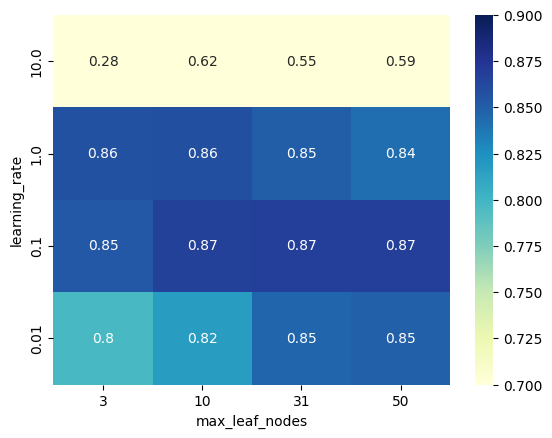

In [20]:
# mapa de calor
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

## **Ejercicio**

Para el dataset "house-prices/full.csv" y usando [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html): 
- Autoajusta max_depth usando grid search.